<a href="https://colab.research.google.com/github/fkvivid/DIVER/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import
import numpy as np
import matplotlib.pyplot as plt
# Evaluation index
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# Download the dataset
from keras.datasets import mnist
(X, y), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(X.shape)
print(X_test.shape)
print(X[0].dtype)

(60000, 28, 28)
(10000, 28, 28)
uint8


In [4]:
X_flat = X.reshape(-1,784)
X_test_flat = X_test.reshape(-1,784)
print(X_flat.shape)
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


In [5]:
# Type conversion, normalization
X_flat = X_flat.astype(np.float)
X_test_flat = X_test_flat.astype(np.float)
X_flat /= 255
X_test_flat /= 255
print(X_flat.max()) # 1.0
print(X_flat.min()) # 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


1.0
0.0


In [6]:
# One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_one_hot = enc.fit_transform(y[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y.shape) # (60000,)
print(y_one_hot.shape) # (60000, 10)
print(y_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [7]:
# Split into training data and validation data
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_flat, y_one_hot, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [11]:
# Scratch Deep Neural Network (for now, 3 layer NN)
class ScratchDeepNeuralNetworkClassifier():
    """
    N Layer Neural Network Classifier
    Parameters
    ----------
    self.sigma : Standard deviation of Gaussian distribution
    self.lr : learning rate
    self.n_nodes1 : Number of nodes in the first layer
    self.n_nodes2 : Number of nodes in the second layer
    self.n_output : Number of nodes in the output layer
    
    self.n_epoch : epoch number
    self.n_batch : Number of batches
    self.verbose : Visualizing the learning process
    Attributes
    ----------
    """
    def __init__(self, n_features, n_nodes1, n_nodes2, n_output,
                 sigma, n_epoch, n_batch, lr, verbose = False):
        # Parameters
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.lr = lr
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        
    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
                
    def fit(self, X, y, X_val=False, y_val=False):
        """
        Train a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data
        y : ndarray of the following form, shape (n_samples, )
            Correct answer value of training data
        X_val : ndarray of the following form, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray of the following form, shape (n_samples, )
            Correct value of validation data
        """
        
        optimizer1 = AdaGrad(self.lr)
        optimizer2 = AdaGrad(self.lr)
        optimizer3 = AdaGrad(self.lr)
        
        initializer1 = XavierInitializer()
        initializer2 = XavierInitializer()
        initializer3 = SimpleInitializer(self.sigma)
        
        self.FC1 = FC(self.n_features, self.n_nodes1, initializer1, optimizer1, Tanh())
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer2, optimizer2, Tanh())
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer3, optimizer3, Softmax())
        
        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # Forward propagation
                self.Z1 = self.FC1.forward(mini_X_train)
                self.Z2 = self.FC2.forward(self.Z1)
                self.Z3 = self.FC3.forward(self.Z2)    

                # Back propagation
                self.dA3 = (self.Z3 - mini_y_train)/self.n_batch
                self.dZ2 = self.FC3.backward(self.dA3)
                self.dZ1 = self.FC2.backward(self.dZ2)
                self.dZ0 = self.FC1.backward(self.dZ1)
                
                # Loss function
                self.loss += self.loss_function(self.Z3,mini_y_train)
                
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            
    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Sample

        Returns
        -------
            ndarray of the following form, shape (n_samples, 1)
            Estimation results
        """
        pred_Z1 = self.FC1.forward(X)
        pred_Z2 = self.FC2.forward(pred_Z1)
        return np.argmax(self.FC3.forward(pred_Z2),axis=1)

In [12]:
# Mini-batch processing class
class GetMiniBatch:
    """
    Iterator to get the mini-batch

    Parameters
    ----------
    X : ndarray of the following form, shape (n_samples, n_features)
      Training data
    y : ndarray of the follwowing form, shape (n_samples, 1)
      correct value
    batch_size : int
      Batch size
    seed : int
      Seeding random numbers in NumPy
    """
    def __init__(self, X, y, batch_size = 20, seed=None):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1] 
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

[Problem 1] Classification of fully connected layers

In [13]:
class FC:
    """
    All coupling layers from number of nodes n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in subsequent layers
    initializer : Instances of initialization methods
    optimizer : Instances of optimization methods
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, activation):
        
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        self.activation = activation
        # Initialize
         # Use the initializer method to initialize self.W and self.B
        self.W = self.initializer.W(self.n_nodes1,self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        forward 
        Parameters
        ----------
        X : ndarray of the following form, shape (batch_size, n_nodes1)
            Input
        Returns
        ----------
        A : ndarray of the following form, shape (batch_size, n_nodes2)
            Output
        """
        self.X = X
        self.A = np.dot(self.X,self.W) + self.B
        
        return self.activation.forward(self.A)
    
    def backward(self, dZ):
        """
        backward
        Parameters
        ----------
        dA : ndarray of the following form, shape (batch_size, n_nodes2)
            The gradient flowed in from behind.
        Returns
        ----------
        dZ : ndarray of the following form, shape (batch_size, n_nodes1)
            forward slope
        """
        dA = self.activation.backward(dZ)
        self.dB = np.mean(dA,axis=0)
        self.dW = np.dot(self.X.T,dA)/len(self.X)
        dZ = np.dot(dA,self.W.T)
        
        # Update
        self = self.optimizer.update(self)
        
        return dZ

[Problem 2] Classification of initialization method

In [14]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

[Problem 3] Classification of optimization methods

In [15]:
class SGD:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer


[Problem 4] Classification of activation function

In [16]:
class Tanh():
    """
    Activation function : Hyperbolic tangent function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        self.Z = np.tanh(self.A)
        return self.Z
    
    def backward(self,dZ):
        return dZ*(1-self.Z**2)


In [17]:
class Sigmoid():
    """
    Activation function : Sigmoid function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        self.Z = 1/(1+np.exp(-self.A))
        
        return self.Z
    
    def backward(self,dZ):
        return dZ*(1-self.Z)*self.Z


In [18]:
class Softmax():
    """
    Activation Function : Softmax Function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        
        return np.exp(A-np.max(A))/np.sum(np.exp(A-np.max(A)),axis=1,keepdims=True)
    
    def backward(self,dZ):
        return dZ

[Problem 5] Creating a ReLU class

In [19]:
class ReLU():
    """
    Activation function : ReLU function
    """
    def __init__(self):
        pass
        
    def forward(self,A):
        self.A = A
        return np.maximum(self.A,0)
    
    def backward(self,dZ):
        
        return np.where(self.A>0,dZ,0)


In [20]:
a = np.array([-1,0,1,9,-1])
b = np.array([1,0,-1,9,-1])

print(np.where(a<0,0,b))

[ 0  0 -1  9  0]


[Problem 6] Initial value of weight

In [21]:
class XavierInitializer():
    """
    Initializing weights with Xavier
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return np.random.randn(n_nodes1, n_nodes2)/np.sqrt(n_nodes1)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)


In [22]:
class HeInitializer():
    """
    Initialization of weights by He
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        Initializing weights
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        W : weight
        """
        return np.random.randn(n_nodes1, n_nodes2)*np.sqrt(2/n_nodes1)
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in subsequent layers

        Returns
        ----------
        B : bias
        """
        return np.zeros(n_nodes2)

【Problem 7】Optimization Method

In [23]:
class AdaGrad:
    """
    stochastic gradient descent method
    Parameters
    ----------
    lr : learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.hW = 0
        self.hB = 0
        
    def update(self, layer):
        """
        Updating the weights and biases of a layer
        Parameters
        ----------
        layer : An instance of the layer before the update
        """
        self.hW += layer.dW*layer.dW
        self.hB = layer.dB*layer.dB
    
        layer.W -= self.lr*layer.dW/(np.sqrt(self.hW) +1e-7)
        layer.B -= self.lr*layer.dB/(np.sqrt(self.hB) +1e-7)
        
        return layer

[Problem 8] Completion of class

In [24]:
clf = ScratchDeepNeuralNetworkClassifier(n_epoch=5, n_features=784,
                                         n_nodes1=400, n_nodes2=200, n_output=10,
                                         sigma=0.01, n_batch=100,
                                         lr = 0.01, verbose = False)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [25]:
print(y_pred)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred)
print('accuracy:{:.3f}'.format(accuracy))

[9 0 1 ... 9 4 2]
accuracy:0.964


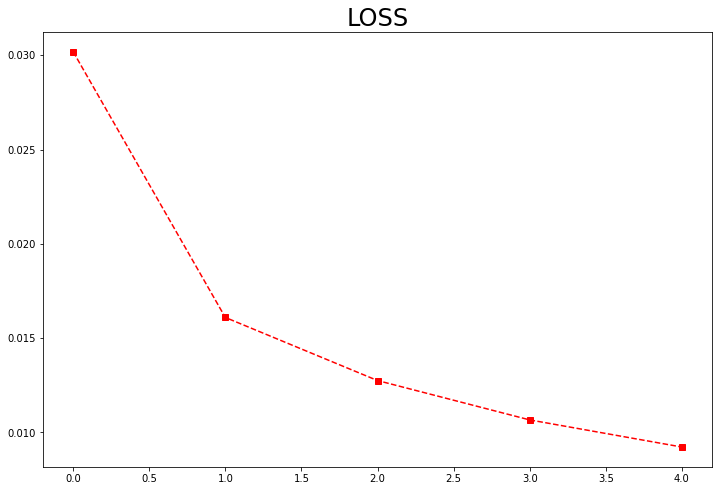

In [26]:
# Visualize the loss function for each epoch
fig = plt.subplots(figsize=(12,8))
plt.rcParams["font.size"] = 20

plt.title('LOSS')
plt.plot(clf.log_loss,'rs--');

[Problem 9] Learning and estimation

In [27]:
# Scratch Deep Neural Networks (if you can do it in any layer)
class ScratchDNNClassifier():
    """
    N Layer Neural Network Classifier
    
    Parameters
    ----------
    self.n_epoch : epoch number
    self.n_batch : Number of batches
    self.verbose : Visualizing the learning process
    Attributes
    ----------
    """
    def __init__(self, NN, n_epoch, n_batch, verbose = False):
        # Parameters
        self.n_epoch = n_epoch
        self.n_batch = n_batch
        self.verbose = verbose
        self.log_loss = np.zeros(self.n_epoch)
        self.log_acc = np.zeros(self.n_epoch)
        self.NN = NN
        
    def loss_function(self,y,yt):
        delta = 1e-7
        return -np.mean(yt*np.log(y+delta))
    
    def accuracy(self,Z,Y):
        return accuracy_score(Y,Z)
                
    def fit(self, X, y, X_val=False, y_val=False):
        """
        Train a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Features of training data
        y : ndarray of the following form, shape (n_samples, )
            Correct answer value of training data
        X_val : ndarray of the following form, shape (n_samples, n_features)
            Features of validation data
        y_val : ndarray of the following form, shape (n_samples, )
            Correct value of validation data
        """
        for epoch in range(self.n_epoch):
            # Mini-batch processing
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.n_batch)
            
            self.loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # Forward propagation
                forward_data = mini_X_train
                for layer in range(len(self.NN)):
                    forward_data = self.NN[layer].forward(forward_data)
                # Predicted value
                Z = forward_data
                
                # Back propagation
                backward_data = (Z - mini_y_train)/self.n_batch
                for layer in range(len(self.NN)-1,-1,-1):
                    backward_data = self.NN[layer].backward(backward_data)
                
                # Loss function
                self.loss += self.loss_function(Z,mini_y_train)
                
            self.log_loss[epoch] = self.loss/len(get_mini_batch)
            self.log_acc[epoch] = self.accuracy(self.predict(X),np.argmax(y,axis=1))
            
    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : ndarray of the following form, shape (n_samples, n_features)
            Sample

        Returns
        -------
            ndarray of the following form, shape (n_samples, 1)
            Estimation results
        """
        pred_data = X
        
        for layer in range(len(self.NN)):
            pred_data = self.NN[layer].forward(pred_data)
            
        return np.argmax(pred_data,axis=1)


In [28]:
NN2 = {0:FC(784, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
       1:FC(400, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       2:FC(200, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
       }
clf2 = ScratchDNNClassifier(NN=NN2,n_epoch=30,n_batch=20,verbose = False)

clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [29]:
print(y_pred2)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred2)
print('accuracy:{:.3f}'.format(accuracy))

[9 0 1 ... 9 4 2]
accuracy:0.972


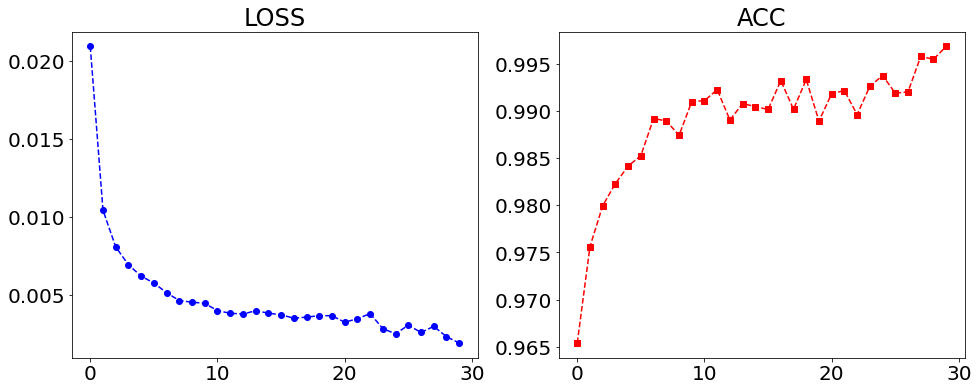

In [30]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf2.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf2.log_acc,'rs--');


In [31]:
NN3 = {0:FC(784, 400, HeInitializer(), AdaGrad(0.01), ReLU()),
       1:FC(400, 600, HeInitializer(), AdaGrad(0.01), ReLU()),
       2:FC(600, 300, HeInitializer(), AdaGrad(0.01), ReLU()),
       3:FC(300, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
       }
clf3 = ScratchDNNClassifier(NN=NN3,n_epoch=30,n_batch=20,verbose = False)

clf3.fit(X_train,y_train)
y_pred3 = clf3.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [32]:
print(y_pred3)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred3)
print('accuracy:{:.3f}'.format(accuracy))

[9 0 1 ... 9 4 2]
accuracy:0.977


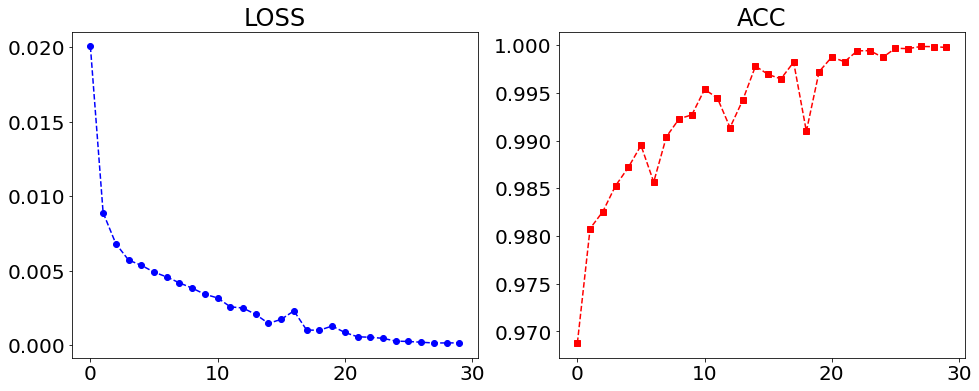

In [33]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf3.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf3.log_acc,'rs--');

In [34]:
NN4 = {0:FC(784, 400, XavierInitializer(), AdaGrad(0.01), Tanh()),
       1:FC(400, 300, XavierInitializer(), AdaGrad(0.01), Sigmoid()),
       2:FC(300, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       3:FC(200, 100, HeInitializer(), AdaGrad(0.01), ReLU()),
       4:FC(100, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
       }
clf4 = ScratchDNNClassifier(NN=NN4,n_epoch=30,n_batch=20,verbose = False)

clf4.fit(X_train,y_train)
y_pred4 = clf4.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [35]:
print(y_pred4)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred4)
print('accuracy:{:.3f}'.format(accuracy))

[9 0 1 ... 9 4 2]
accuracy:0.963


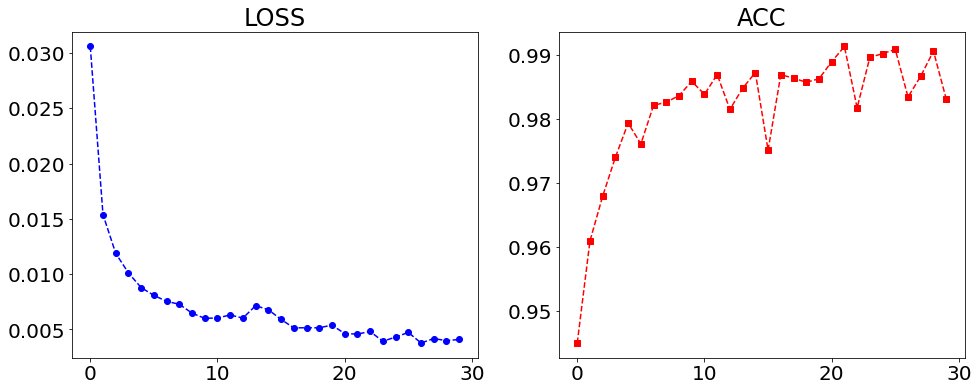

In [36]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf4.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf4.log_acc,'rs--');

In [37]:

NN5 = {0:FC(784, 400, XavierInitializer(), AdaGrad(0.01), Tanh()),
       1:FC(400, 300, HeInitializer(), AdaGrad(0.01), ReLU()),
       2:FC(300, 200, HeInitializer(), AdaGrad(0.01), ReLU()),
       3:FC(200, 100, HeInitializer(), AdaGrad(0.01), ReLU()),
       4:FC(100, 10, SimpleInitializer(0.01), AdaGrad(0.01), Softmax()),
       }

In [38]:
clf5 = ScratchDNNClassifier(NN=NN5,n_epoch=30,n_batch=20,verbose = False)

clf5.fit(X_train,y_train)
y_pred5 = clf5.predict(X_valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [39]:
print(y_pred5)

accuracy = accuracy_score(np.argmax(y_valid,axis=1), y_pred5)
print('accuracy:{:.3f}'.format(accuracy))

[9 0 1 ... 9 4 2]
accuracy:0.973


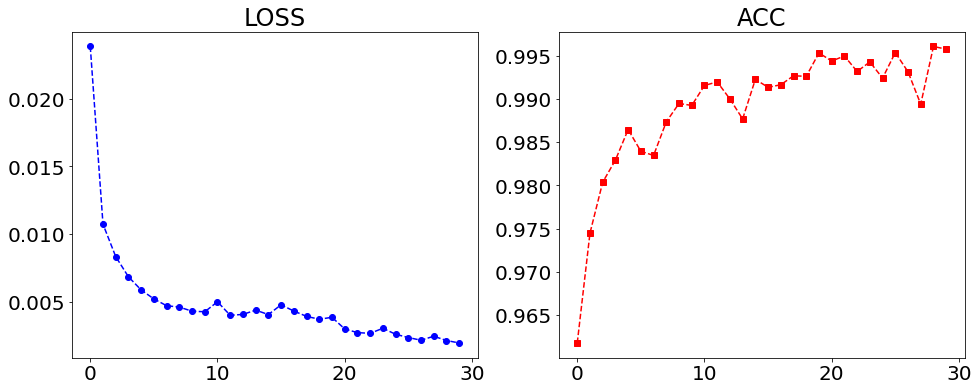

In [40]:
# Visualize the loss function for each epoch
plt.rcParams["font.size"] = 20
fig=plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('LOSS')
plt.plot(clf5.log_loss,'bo--')

plt.subplot(1,2,2)
plt.title('ACC')
plt.plot(clf5.log_acc,'rs--');